In [6]:

from ultralytics import YOLO

import numpy as np

HOME = os.getcwd()
import torch
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import CLIPModel, CLIPProcessor

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/baiporthn/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
import os
HOME = os.getcwd()
print(HOME)

/Users/baiporthn/Documents/MedicineBoxReg/code/pipeline


In [8]:


class BasePredictor:
    def predict(self, image, class_names):
        raise NotImplementedError


class CLIPPredictor(BasePredictor):
    def __init__(self, clip_model, clip_processor):
        self.clip_model = clip_model
        self.clip_processor = clip_processor

    def predict(self, image, class_names):
        inputs = self.clip_processor(text=class_names, images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        return outputs.logits_per_image  # [1, num_classes]


class ImageObjectPipeline:
    def __init__(self, yolo_model, predictor, confidence_threshold=0.5):
        self.yolo_model = yolo_model
        self.predictor = predictor
        self.confidence_threshold = confidence_threshold

    def get_yolo_predictions(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.yolo_model(image_path)

        if len(results[0].boxes) == 0:
            print("No objects detected.")
            return [], img

        predictions = results[0].boxes.data.cpu().numpy()
        bboxes = predictions[:, :4]
        confidences = predictions[:, 4]
        valid_indices = confidences > self.confidence_threshold
        bboxes = bboxes[valid_indices]

        return bboxes, img

    def crop_image(self, image, bbox):
        x_min, y_min, x_max, y_max = map(int, bbox)
        pil_img = Image.fromarray(image)
        return pil_img.crop((x_min, y_min, x_max, y_max))

    def draw_box(self, image, bbox, label):
        draw = ImageDraw.Draw(image)
        x_min, y_min, x_max, y_max = map(int, bbox)
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
        draw.text((x_min, y_min - 10), label, fill="red")
        return image

    def process_image(self, image_path, class_names):
        bboxes, img = self.get_yolo_predictions(image_path)
        pil_img = Image.fromarray(img)

        for i, bbox in enumerate(bboxes):
            cropped_img = self.crop_image(img, bbox)
            probs = self.predictor.predict(cropped_img, class_names)  # shape: [1, num_classes]
            predicted_idx = probs.argmax(dim=1).item()
            predicted_class = class_names[predicted_idx]
            predicted_prob = probs[0][predicted_idx].item()

            print(f"Object {i+1}: Predicted class: {predicted_class} (confidence: {predicted_prob:.4f})")

            # Show cropped image with prediction
            plt.imshow(cropped_img)
            plt.title(f"Predicted: {predicted_class}")
            plt.axis("off")
            plt.show()

            # Draw bbox on original image
            self.draw_box(pil_img, bbox, predicted_class)

        # Show full image with all boxes and labels
        plt.figure(figsize=(10, 10))
        plt.imshow(pil_img)
        plt.title("All predictions on image")
        plt.axis("off")
        plt.show()



image 1/1 /Users/baiporthn/Documents/MedicineBoxReg/code/pipeline/sample/aferin.jpg: 640x640 1 aferin, 248.8ms
Speed: 7.1ms preprocess, 248.8ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 640)
Object 1: Predicted class: aferin (confidence: 28.9095)


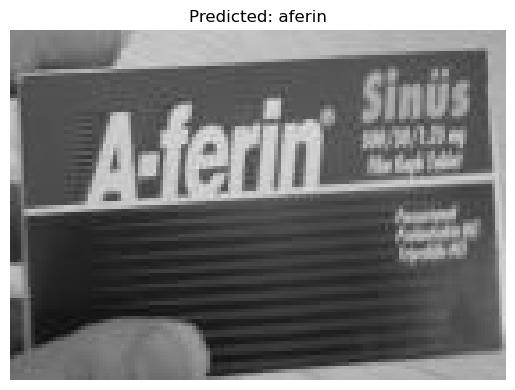

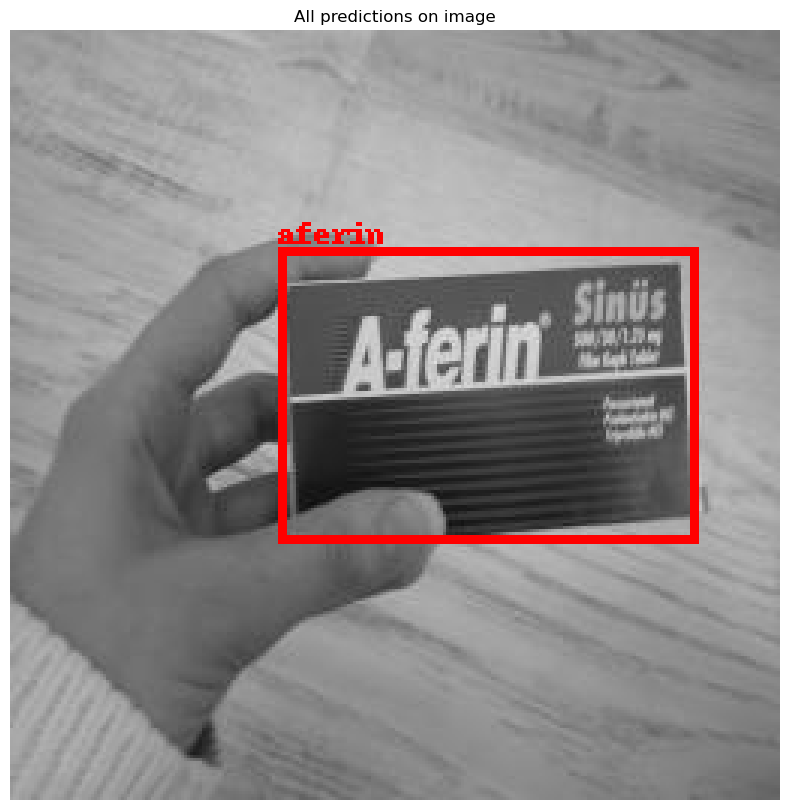

In [9]:
# Load models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_predictor = CLIPPredictor(clip_model, clip_processor)

yolo_path = os.path.join(HOME, 'train17/weights/best.pt')
# Load the YOLOv8 model with your trained weights (weights.pt)
yolo_model = YOLO(yolo_path)  # Update with correct path to your .pt file

pipeline = ImageObjectPipeline(yolo_model, clip_predictor)

# Define your custom class names for zero-shot classification
custom_class_names = ["ibuprofen", "paracetamol", "aspirin", "unisom", "benadryl", "aferin"]

pipeline.process_image(os.path.join(HOME, "sample/aferin.jpg"), custom_class_names)



image 1/1 /Users/baiporthn/Documents/MedicineBoxReg/code/pipeline/sample/heartD/isosorbide.jpg: 640x640 1 apranax, 115.6ms
Speed: 12.8ms preprocess, 115.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Object 1: Predicted class: Isosorbide mononitrate (confidence: 37.5331)


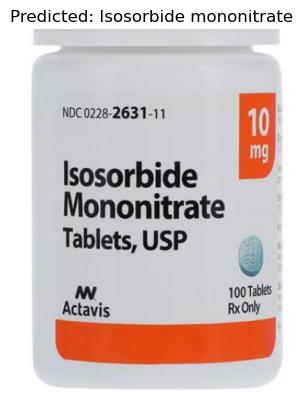

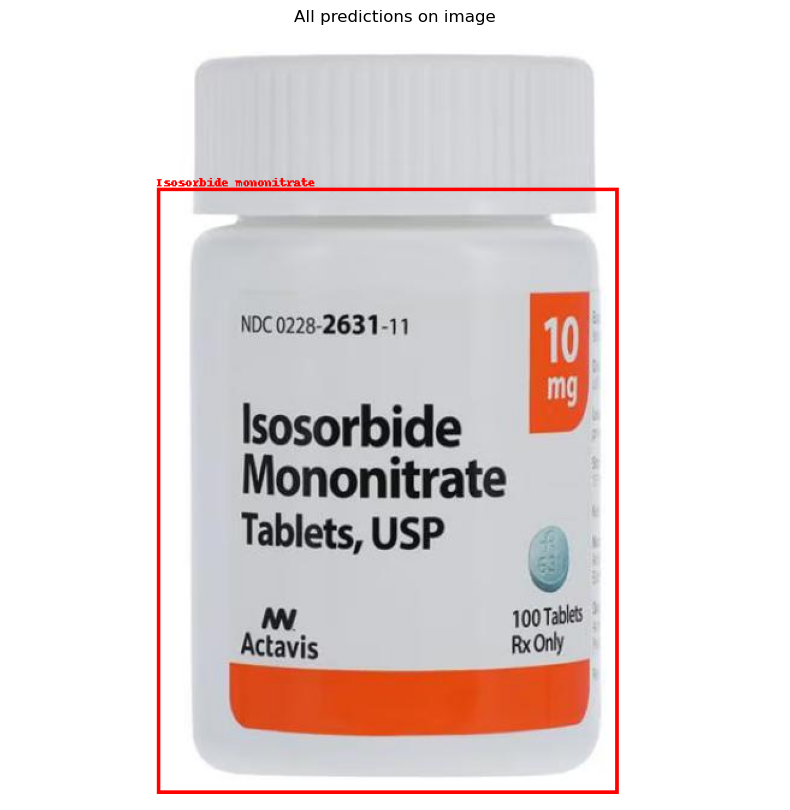

In [14]:
pipeline = ImageObjectPipeline(yolo_model, clip_predictor)

# Define your custom class names for zero-shot classification
custom_class_names = ['Amiodarone', 'Amlodipine', 'Apixaban', 'Aspirin', 'Atorvastatin', 
                      'Caduet', 'Candesartan', 'Carvedilol', 'Clopidogrel', 'Dabigatran',
                      'Digoxin', 'Diltiazem', 'Eplerenone', 'Exforge', 'Furosemide', 
                      'Glyceryl trinitrate', 'Hydrochlorothiazide', 'Isosorbide mononitrate',
                      'Metoprolol', 'Perindopril', 'Rivaroxaban', 'Rosuvastatin', 'Simvastatin',
                      'Spironolactone', 'Statins', 'Ticagrelor', 'Valsartan', 'Warfarin', 'ramipril']

pipeline.process_image(os.path.join(HOME, "sample/heartD/isosorbide.jpg"), custom_class_names)